In [1]:
%run init_notebook.py

In [2]:
from src.nlp_lists import DICT_NARRATIVES, LST_FREQUENT_NON_MEANING
from settings import MODELS_DIR

In [3]:
import pickle
import spacy

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import RandomizedSearchCV

import time
import gc

from scipy.stats import uniform

In [4]:
from src.utils import load_pickle, save_pkl, save_pd_df
from src.nlp_utils import get_lda_n_top_words, PTWGuidedLatentDirichletAllocation

# load data

In [5]:
lst_files = [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']]
# lst_files = [lst_files[i] for i in np.random.randint(0, high=len(lst_files), size=2_000)]

In [6]:
dict_txts = {}
for file in lst_files:
    dict_txts[file.split('.')[0]] = load_pickle(file)
len(dict_txts)

1580

In [7]:
lst_noun_tokens = [list(i['counter_nouns'].keys()) for i in dict_txts.values()] # i['date'] >= datetime(2012,1,1).date()]
lst_noun_tokens = [[i for i in lst if i not in LST_FREQUENT_NON_MEANING] for lst in lst_noun_tokens]

lst_dates = [i['date'] for i in dict_txts.values()]
lst_ids = list(dict_txts.keys())

# vectorize

In [8]:
voc = list(set([*chain(*lst_noun_tokens)]))
vectorizer = CountVectorizer(ngram_range=(1,1), vocabulary=voc,)
vec = vectorizer.fit_transform([" ".join(i) for i in lst_noun_tokens])
X = vec.toarray()
dict_txt2vec = vectorizer.vocabulary_

In [9]:
del lst_noun_tokens, dict_txts
gc.collect()

0

# lda sklearn

In [10]:
lda = LatentDirichletAllocation(
    n_components=len(DICT_NARRATIVES),
    learning_decay=.8,
    learning_offset=10,
    learning_method='online',
    batch_size=5_000,
    random_state=101
)
out_lda = lda.fit(X)

In [11]:
get_lda_n_top_words(voc, out_lda)


Topic 0
preis problem liebe geld beziehung wirtschaft schatz inflation mensch karriere

Topic 1
preis inflation unternehmen geld ezb europa usa zentralbank inflationsrate wirtschaft

Topic 2
inflation preis ezb zentralbank notenbank zins geld energie inflationsrate geldpolitik

Topic 3
preis haus eingang mensch welt kosten grund markt unternehmen zukunft

Topic 4
inflation unternehmen kosten preis geld mitarbeiter wert mensch notenbank folge

Topic 5
preis inflation mensch markt staat usa folge wirtschaft nachfrage regierung

Topic 6
inflation unternehmen aktie fakten usa anleger rendite preis dollar kurs

Topic 7
inflation preis unternehmen zins wirtschaft geld usa ezb zentralbank inflationsrate

Topic 8
inflation etoro tereza ipek ottonello laidler ranosova blanco ozkardeskaya abschnitt

Topic 9
eigentümer trendradar angleichungsprozess angestelltenverhältniss drift betriebsinhaber freiheitsgrad betriebsüberschüs mittelstandspolitik arbeitnehmerentgelt

Topic 10
preis markt wert auf

In [13]:
df = pd.DataFrame(out_lda.transform(X), index=lst_dates)
df.sort_index(inplace=True)

# lda prior

In [10]:
lst_topic_seeds = [[*chain(*list(v.values()))] for k, v in DICT_NARRATIVES.items()]
lst_topic_seeds_num = [[dict_txt2vec[w] for w in topic if w in dict_txt2vec.keys()] for topic in lst_topic_seeds]

In [13]:
plda = PTWGuidedLatentDirichletAllocation(
    n_components=len(lst_topic_seeds),
    learning_decay=.8,
    learning_offset=100,
    learning_method='online',
    batch_size=900,
    random_state=101,
    ptws=lst_topic_seeds_num,
    n_jobs=-1,
)

In [ ]:
plda_out = plda.fit(vec.toarray())

In [12]:
get_lda_n_top_words(voc, plda_out)


Topic 0
inflation inflationsrate preissteigerung teuerung verbraucherpreis inflationserwartung kaufpreis ökonom wirtschaft mensch

Topic 1
lohn arbeitnehmer beschäftigter mitarbeiter gehalt arbeitslosigkeit lohnsteigerung beschäftigung arbeitslosenquote gehaltssteigerung

Topic 2
lieferkette handel import halbleiter engpass industrie folge unternehmen grund kostenoptimierung

Topic 3
kosten angebot produktion hersteller produktionskosten produktionskapazität angebotsschock angebotsknappheit geld mensch

Topic 4
ukraine krieg russland konflikt sanktion europa usa geld wert wirtschaft

Topic 5
preis energie gas öl strom erdgas nord stream pipeline unternehmen

Topic 6
gewinn unternehmensgewinn profit profitabilität rekordgewinn gierflation übergewinnsteuer gewinnmitnahm übergewinn gewinnabschöpfung

Topic 7
pandemie corona lockdowns lockdown virus covid unternehmen wirtschaft china usa

Topic 8
zins unternehmen wirtschaft geld usa ezb zentralbank notenbank wert folge

Topic 9
pepp kaufp

## cross validation random search

In [14]:
cv_plda = RandomizedSearchCV(plda,
                             dict(
                                 learning_decay=uniform(.7,.1),
                                 learning_offset=uniform(10, 90),
                                 ptws_bias=uniform(len(lst_topic_seeds)-5, len(lst_topic_seeds)+5),
                                 # batch_size=2_000,
                             ),
                             n_iter=25,
                             n_jobs=-1,
                             random_state=101,                             
                            )

In [ ]:
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=3):
    cv_plda_out = cv_plda.fit(vec.toarray())
    out_plda_cv = cv_plda_out.best_estimator_

In [ ]:
get_lda_n_top_words(voc, out_plda_cv)

## plot

In [15]:
df = pd.DataFrame(out_plda_cv.transform(X), columns=DICT_NARRATIVES.keys(), index=lst_dates)
df.sort_index(inplace=True)

df_g = df.reset_index().groupby('index').sum() #/ df.reset_index().groupby('index').inflation.count().values[:,None]).copy()
df_g = df_g.rolling(10).mean()

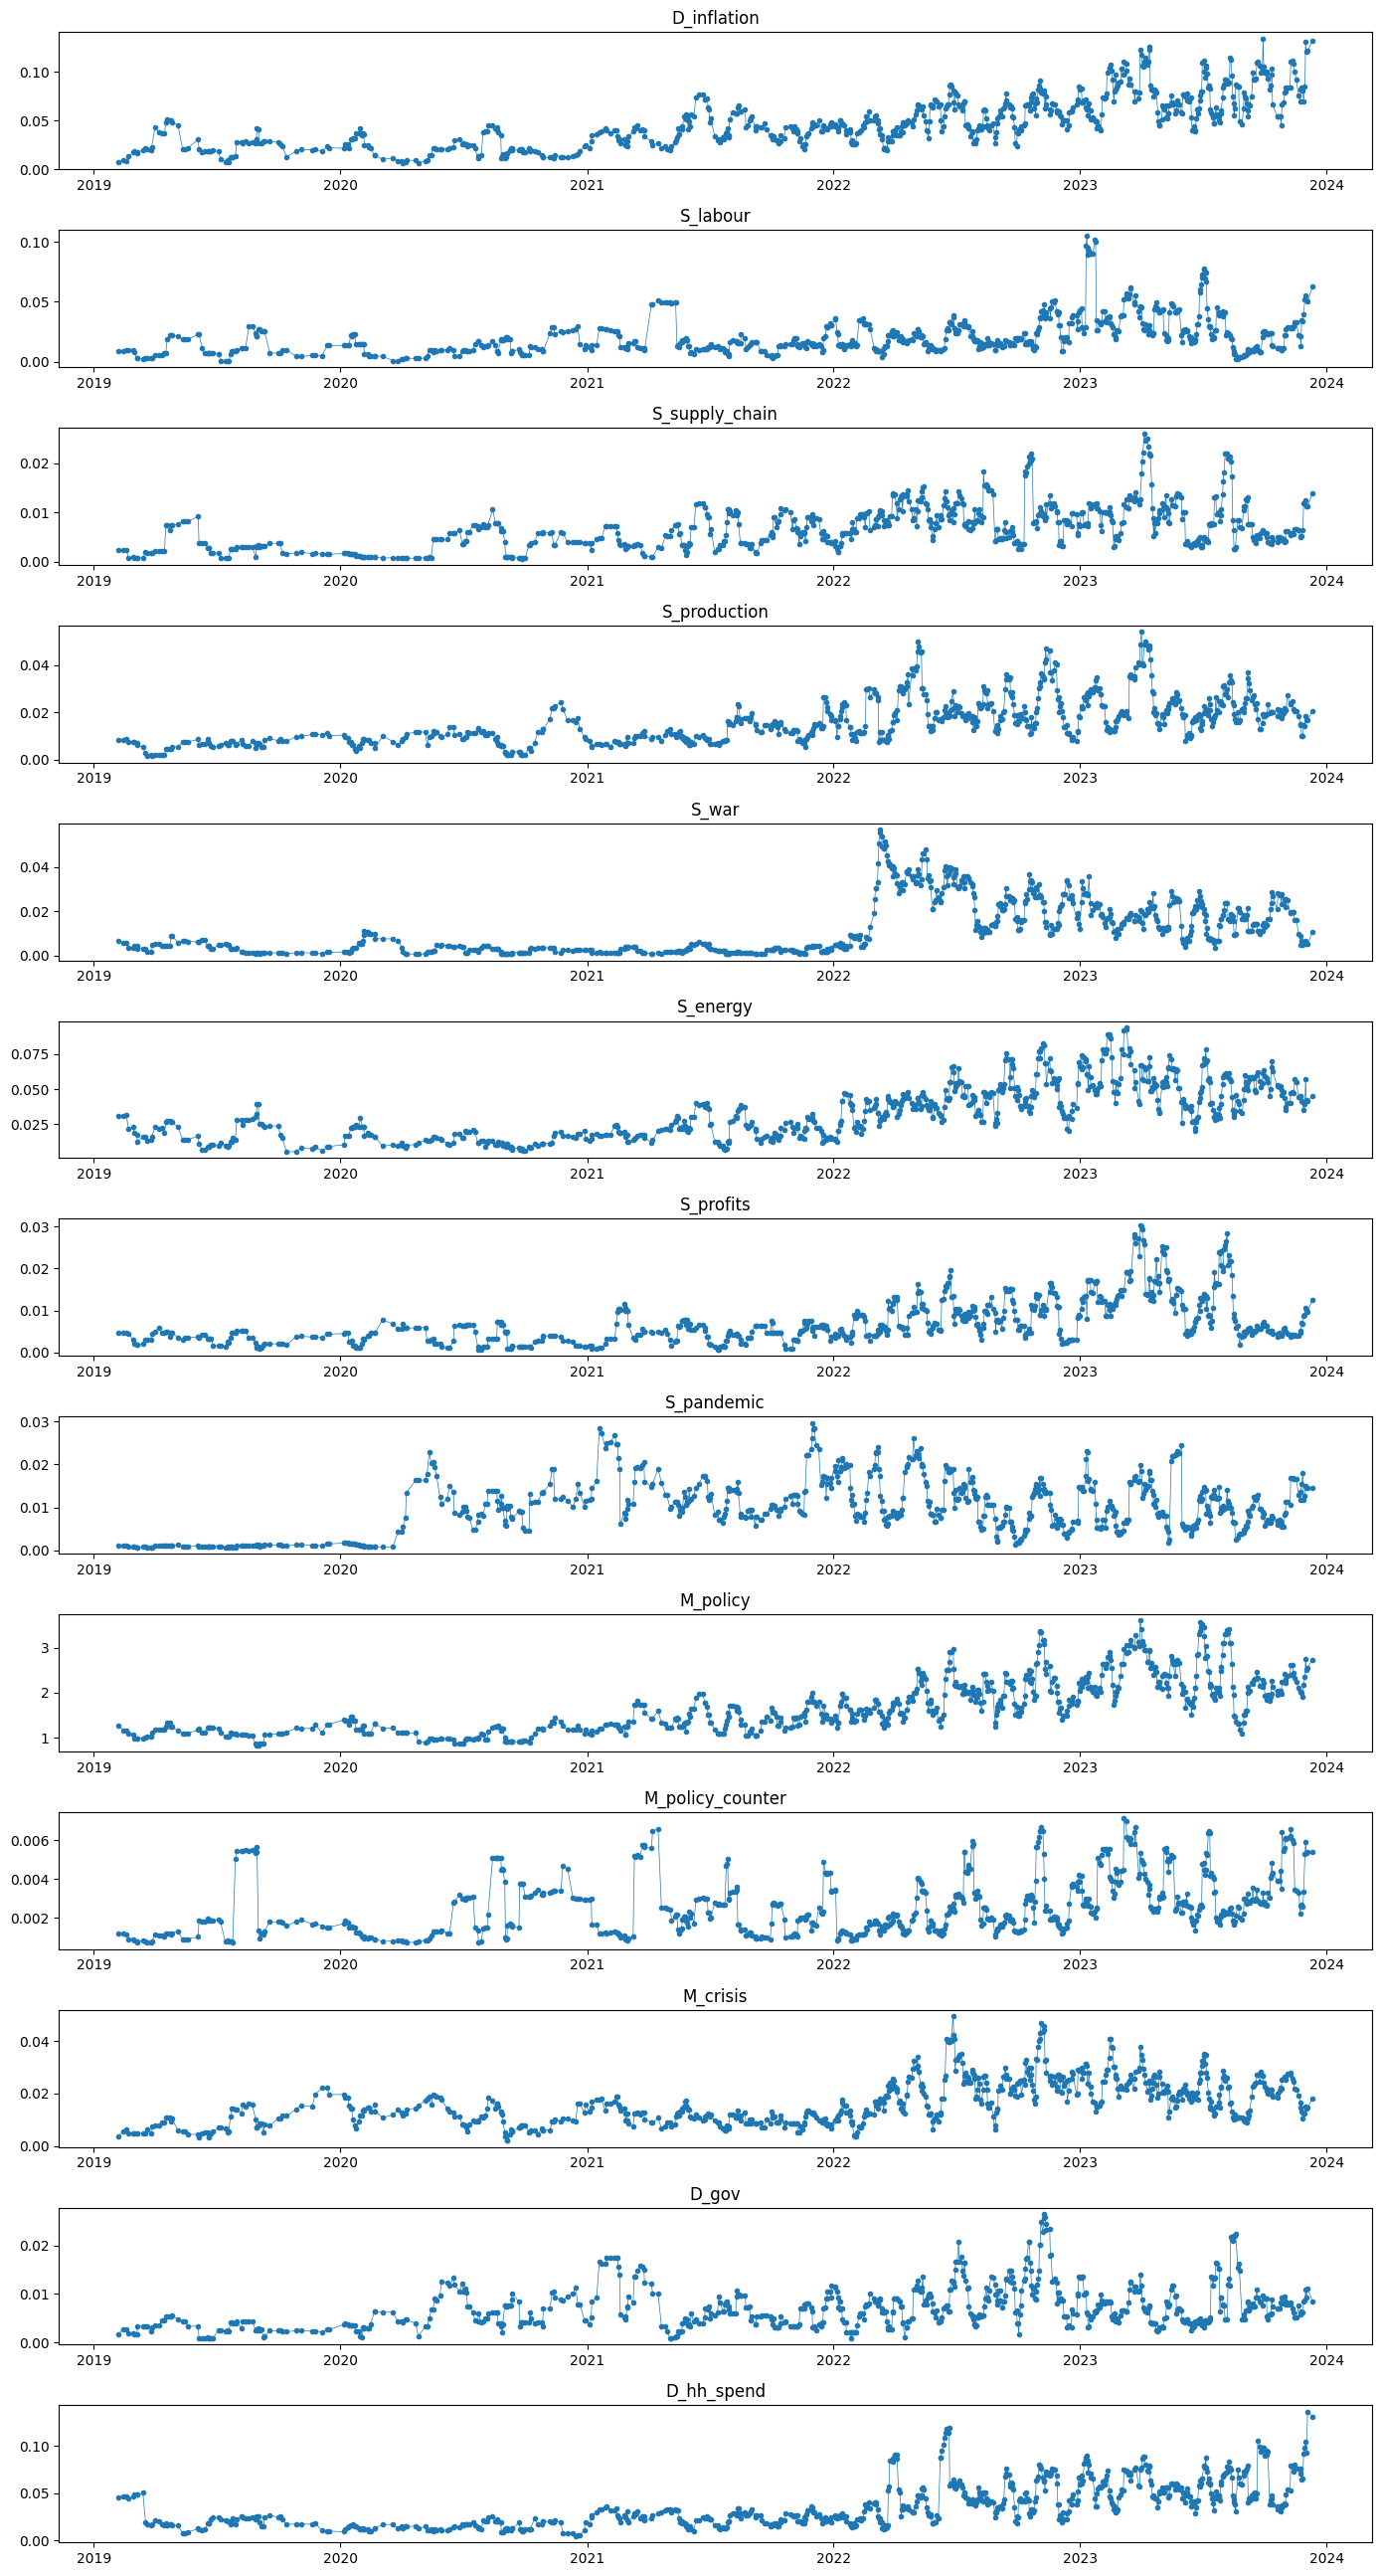

In [16]:
fig, axes = plt.subplots(df.shape[1], 1, figsize=(14, 2*df.shape[1]))
for idx, ax in enumerate(axes.ravel()):
    ax.plot(df_g.iloc[:, idx], lw=.5, marker='.')
    ax.set_title(df_g.columns[idx])
plt.tight_layout()

In [17]:
df.index.name = 'date'
df['id'] = lst_ids

save_pd_df(df, "lda_topics.feather")

In [ ]:
save_pkl(out_plda_cv, 'plda_cv_v02.pkl', f_path=MODELS_DIR)